# Problème des Mariages Stables : Gale-Shapley vs CSP avec OR-Tools

## Objectif
Comparer l'algorithme classique **Gale-Shapley** avec une approche par **Programmation par Contraintes (CSP)** utilisant OR-Tools pour résoudre le problème des mariages stables.

### Structure du Notebook
1. **Phase 1** : Setup et implémentation Gale-Shapley (ground truth)
2. **Phase 2** : Approche CSP avec OR-Tools
3. **Phase 3-4** : Validation, benchmarking et visualisation

### Concepts Théoriques
- **Gale-Shapley** : Algorithme glouton en O(n²), garantit une solution stable
- **CSP** : Modélisation des contraintes de bijection et non-stabilité des paires bloquantes
- **Complexité** : CSP peut être exponentielle en général, mais on cherche à explorer les performances pratiques

In [18]:
import sys
!{sys.executable} -m pip install ortools

# ============================================================================
# PHASE 1 : IMPORTATIONS ET SETUP
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ortools.sat.python import cp_model
import time
from typing import Dict, List, Tuple, Set
from dataclasses import dataclass

# Configuration matplotlib pour les graphiques
plt.style.use('seaborn-v0_8-darkgrid')
print("✓ Toutes les dépendances importées avec succès")

✓ Toutes les dépendances importées avec succès


## Phase 1 : Génération des données et Ground Truth

### 1.1 - Génération des matrices de préférences

Nous générons deux matrices (n × n) de préférences aléatoires :
- `men_prefs[i]` = préférences de l'homme i (permutation de 0..n-1)
- `women_prefs[j]` = préférences de la femme j (permutation de 0..n-1)

In [19]:
def generate_preferences(n: int, seed: int = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Génère deux matrices de préférences aléatoires pour le problème des mariages stables.

    Args:
        n: Nombre d'hommes et de femmes
        seed: Graine pour la reproductibilité (optionnel)

    Returns:
        - men_prefs: Matrice (n x n) où men_prefs[i] = préférences de l'homme i
        - women_prefs: Matrice (n x n) où women_prefs[j] = préférences de la femme j

    Détails:
        Chaque ligne est une permutation aléatoire de [0, 1, ..., n-1].
        Interprétation : men_prefs[i][j] = rang de la femme men_prefs[i][j] dans les préférences de i
    """
    if seed is not None:
        np.random.seed(seed)

    # Génération des matrices : chaque ligne est une permutation aléatoire
    men_prefs = np.array([np.random.permutation(n) for _ in range(n)])
    women_prefs = np.array([np.random.permutation(n) for _ in range(n)])

    return men_prefs, women_prefs


# Exemple d'utilisation avec petit n
n_test = 5
men_prefs_test, women_prefs_test = generate_preferences(n_test, seed=42)

print(f"Exemple avec n={n_test}:")
print(f"\nPréférences des hommes:")
print(men_prefs_test)
print(f"\nPréférences des femmes:")
print(women_prefs_test)
print(f"\nExplication : L'homme 0 préfère la femme {men_prefs_test[0][0]} en premier, puis {men_prefs_test[0][1]}, etc.")

Exemple avec n=5:

Préférences des hommes:
[[1 4 2 0 3]
 [3 1 2 0 4]
 [1 0 3 4 2]
 [0 1 2 3 4]
 [0 2 3 1 4]]

Préférences des femmes:
[[4 2 0 3 1]
 [2 0 4 1 3]
 [1 2 4 0 3]
 [0 3 1 4 2]
 [0 1 2 4 3]]

Explication : L'homme 0 préfère la femme 1 en premier, puis 4, etc.


### 1.2 - Implémentation de l'algorithme Gale-Shapley

L'algorithme Gale-Shapley (version "Men-Proposing") fonctionne ainsi :
1. Chaque homme libre propose à la femme qu'il préfère le plus parmi celles non encore proposées
2. La femme accepte si elle est libre OU si elle préfère ce nouvel homme à son mari actuel
3. Si un homme est rejeté, il passe à sa femme suivante dans son classement
4. Process continue jusqu'à ce que tous les hommes soient engagés

**Complexité** : O(n²) - au maximum n(n-1) propositions

**Propriété clé** : La solution est toujours **stable** (aucune paire bloquante)

In [20]:
def gale_shapley(men_prefs: np.ndarray, women_prefs: np.ndarray) -> Dict[int, int]:
    """
    Algorithme Gale-Shapley (Men-Proposing) pour le problème des mariages stables.

    Args:
        men_prefs: Matrice (n x n) des préférences des hommes
        women_prefs: Matrice (n x n) des préférences des femmes

    Returns:
        Dictionnaire {homme: femme} représentant le matching stable

    Complexité: O(n²)

    Théorie:
        - Les hommes proposent toujours à la femme qu'ils préfèrent le plus disponible
        - Les femmes acceptent si elles sont libres ou si le nouveau candidat est meilleur
        - Solution garantie stable et unique (du point de vue des hommes)
    """
    n = len(men_prefs)

    # Structures de données
    wife_of = [-1] * n  # husband[m] = femme de l'homme m (-1 = libre)
    husband_of = [-1] * n  # husband[w] = mari de la femme w (-1 = libre)
    next_proposal = [0] * n  # next_proposal[m] = index du prochain candidat pour l'homme m

    # Matrice de rangs des préférences des femmes (pour les comparaisons rapides)
    # ranking_w[w][m] = rang de l'homme m dans les préférences de la femme w
    ranking_w = np.zeros((n, n), dtype=int)
    for w in range(n):
        for rank, m in enumerate(women_prefs[w]):
            ranking_w[w][m] = rank

    # File des hommes libres
    free_men = list(range(n))

    while free_men:
        man = free_men.pop(0)

        # L'homme propose à sa prochaine femme préférée
        woman = men_prefs[man][next_proposal[man]]
        next_proposal[man] += 1

        if husband_of[woman] == -1:
            # La femme est libre : engagement
            wife_of[man] = woman
            husband_of[woman] = man
        else:
            # La femme est engagée : elle compare les deux hommes
            current_husband = husband_of[woman]
            if ranking_w[woman][man] < ranking_w[woman][current_husband]:
                # La femme préfère le nouvel homme
                wife_of[man] = woman
                husband_of[woman] = man
                free_men.append(current_husband)  # L'ancien mari devient libre
            else:
                # La femme refuse : l'homme redevient libre
                free_men.append(man)

    # Convertir en dictionnaire {homme: femme}
    return {m: wife_of[m] for m in range(n)}


# Test avec l'exemple précédent
matching_gs = gale_shapley(men_prefs_test, women_prefs_test)
print(f"\nMatching Gale-Shapley pour n={n_test}:")
for man, woman in matching_gs.items():
    print(f"  Homme {man} ↔ Femme {woman}")


Matching Gale-Shapley pour n=5:
  Homme 0 ↔ Femme 4
  Homme 1 ↔ Femme 3
  Homme 2 ↔ Femme 1
  Homme 3 ↔ Femme 2
  Homme 4 ↔ Femme 0


## Phase 2 : Approche CSP avec OR-Tools

### 2.1 - Modélisation du problème en CSP

La modélisation CSP comprend :

**Variables de décision :**
- `wife_of[m]` pour chaque homme m ∈ [0, n-1], domaine = [0, n-1]

**Contraintes :**
1. **Bijection** : Utiliser `AddAllDifferent(wife_of)` pour garantir un matching parfait (injection)
2. **Stabilité** : Pour chaque paire (m, w), interdire que ce soit une paire bloquante

**Définition formelle d'une paire bloquante :**
Une paire (m, w) est bloquante si :
- m préfère w à sa femme actuelle ET
- w préfère m à son mari actuel

**Astuce d'implémentation** : Pré-calculer les matrices de rangs pour éviter les recherches linéaires dans les listes de préférences

In [21]:
def solve_stable_marriage_csp(men_prefs: np.ndarray, women_prefs: np.ndarray) -> Dict[int, int]:
    """
    Résout le problème des mariages stables en utilisant la Programmation par Contraintes.

    Args:
        men_prefs: Matrice (n x n) des préférences des hommes
        women_prefs: Matrice (n x n) des préférences des femmes

    Returns:
        Dictionnaire {homme: femme} représentant le matching stable

    Approche CSP:
        1. Créer des variables wife_of[m] pour chaque homme m
        2. Ajouter la contrainte AllDifferent pour la bijection
        3. Pour chaque paire (m, w), ajouter une contrainte interdisant les paires bloquantes
    """
    n = len(men_prefs)

    # Créer le modèle CSP
    model = cp_model.CpModel()

    # ÉTAPE 1 : Créer les variables de décision
    # wife_of[m] = index de la femme mariée à l'homme m
    wife_of = [model.NewIntVar(0, n-1, f'wife_of_{m}') for m in range(n)]

    # ÉTAPE 2 : Contrainte de bijection (chaque femme exactement une fois)
    model.AddAllDifferent(wife_of)

    # ÉTAPE 3 : Contrainte de stabilité (pas de paires bloquantes)
    # Pour exprimer efficacement les contraintes, on pré-calcule les matrices de rangs

    # rank_m[m][w] = position de la femme w dans les préférences de l'homme m
    rank_m = np.zeros((n, n), dtype=int)
    for m in range(n):
        for rank, w in enumerate(men_prefs[m]):
            rank_m[m][w] = rank

    # rank_w[w][m] = position de l'homme m dans les préférences de la femme w
    rank_w = np.zeros((n, n), dtype=int)
    for w in range(n):
        for rank, m_val in enumerate(women_prefs[w]): # Renamed m to m_val to avoid conflict with loop variable
            rank_w[w][m_val] = rank

    # Créer les variables inverses : husband_of[w] pour chaque femme w
    husband_of = [model.NewIntVar(0, n-1, f'husband_of_{w}') for w in range(n)]

    # Établir la correspondance : si wife_of[m] = w, alors husband_of[w] = m
    # Utilise AddInverse pour lier les variables wife_of et husband_of
    model.AddInverse(wife_of, husband_of)

    # Maintenant ajouter les contraintes de stabilité
    # Une paire (m, w) n'est pas bloquante si :
    # NOT (m préfère w à wife_of[m]) OR NOT (w préfère m à husband_of[w])
    for m in range(n):
        for w in range(n):
            # On utilise des variables intermédiaires booléennes
            m_prefers_w = model.NewBoolVar(f'm_prefers_{m}_to_{w}')
            w_prefers_m = model.NewBoolVar(f'w_prefers_{w}_to_{m}')

            # --- Condition 1 : m préfère-t-il w à sa femme actuelle ? ---
            # Variable pour stocker le rang de la femme actuelle de m dans les préférences de m
            rank_m_wife_of_m = model.NewIntVar(0, n - 1, f'rank_m_wife_of_{m}')
            # Lier wife_of[m] à son rang pour m en utilisant AddElement
            # rank_m[m] est un tableau numpy d'entiers représentant les préférences de m
            model.AddElement(wife_of[m], rank_m[m].tolist(), rank_m_wife_of_m)

            # Equivalence: m_prefers_w <=> (rank_m[m][w] < rank_m_wife_of_m)
            # Implication 1: m_prefers_w => (rank_m[m][w] < rank_m_wife_of_m)
            # Equivalent to: NOT m_prefers_w OR (rank_m[m][w] < rank_m_wife_of_m)
            model.AddBoolOr([~m_prefers_w, rank_m[m][w] < rank_m_wife_of_m])

            # Implication 2: (rank_m[m][w] < rank_m_wife_of_m) => m_prefers_w
            # Equivalent to: NOT (rank_m[m][w] < rank_m_wife_of_m) OR m_prefers_w
            # Equivalent to: (rank_m[m][w] >= rank_m_wife_of_m) OR m_prefers_w
            model.AddBoolOr([m_prefers_w, rank_m[m][w] >= rank_m_wife_of_m])

            # --- Condition 2 : w préfère-t-elle m à son mari actuel ? ---
            # Variable pour stocker le rang du mari actuel de w dans les préférences de w
            rank_w_husband_of_w = model.NewIntVar(0, n - 1, f'rank_w_husband_of_{w}')
            # Lier husband_of[w] à son rang pour w en utilisant AddElement
            # rank_w[w] est un tableau numpy d'entiers représentant les préférences de w
            model.AddElement(husband_of[w], rank_w[w].tolist(), rank_w_husband_of_w)

            # Equivalence: w_prefers_m <=> (rank_w[w][m] < rank_w_husband_of_w)
            # Implication 1: w_prefers_m => (rank_w[w][m] < rank_w_husband_of_w)
            # Equivalent to: NOT w_prefers_m OR (rank_w[w][m] < rank_w_husband_of_w)
            model.AddBoolOr([~w_prefers_m, rank_w[w][m] < rank_w_husband_of_w])

            # Implication 2: (rank_w[w][m] < rank_w_husband_of_w) => w_prefers_m
            # Equivalent to: NOT (rank_w[w][m] < rank_w_husband_of_w) OR w_prefers_m
            # Equivalent to: (rank_w[w][m] >= rank_w_husband_of_w) OR w_prefers_m
            model.AddBoolOr([w_prefers_m, rank_w[w][m] >= rank_w_husband_of_w])

            # Interdire la paire bloquante : NOT (m_prefers_w AND w_prefers_m)
            # Équivalent à : NOT m_prefers_w OR NOT w_prefers_m
            model.AddBoolOr([~m_prefers_w, ~w_prefers_m])

    # ÉTAPE 4 : Résoudre
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # Extraire la solution
        matching = {}
        for m in range(n):
            matching[m] = solver.Value(wife_of[m])
        return matching
    else:
        raise ValueError("CSP solver did not find a feasible solution")


# Test avec un petit exemple
print(f"\n{'='*60}")
print(f"Test CSP avec n={n_test}:")
print(f"{'='*60}")
try:
    matching_csp = solve_stable_marriage_csp(men_prefs_test, women_prefs_test)
    print(f"\nMatching CSP pour n={n_test}:")
    for man, woman in matching_csp.items():
        print(f"  Homme {man} ↔ Femme {woman}")
except Exception as e:
    print(f"Erreur lors de la résolution CSP : {e}")


Test CSP avec n=5:
Erreur lors de la résolution CSP : Evaluating a BoundedLinearExpression 'rank_m_wife_of_0 >= 4'instance as a Boolean is not supported.


## Phase 3 : Validation des solutions

### 3.1 - Vérification de la stabilité

Une solution est stable si aucune paire bloquante n'existe. Une paire (m, w) est bloquante si m préfère w à sa femme actuelle ET w préfère m à son mari actuel.

In [22]:
def is_stable(matching: Dict[int, int], men_prefs: np.ndarray, women_prefs: np.ndarray) -> Tuple[bool, List[Tuple[int, int]]]:
    """
    Vérifie qu'un matching est stable (aucune paire bloquante).

    Args:
        matching: Dictionnaire {homme: femme}
        men_prefs: Matrice des préférences des hommes
        women_prefs: Matrice des préférences des femmes

    Returns:
        - is_stable: Booléen indiquant la stabilité
        - blocking_pairs: Liste des paires bloquantes (si instable)

    Théorie:
        Une paire (m, w) est bloquante ssi :
        - m préfère w à sa femme actuelle ET
        - w préfère m à son mari actuel
    """
    n = len(men_prefs)

    # Créer la correspondance inverse {femme: homme}
    husband_of = {w: m for m, w in matching.items()}

    # Matrice de rangs pour les comparaisons rapides
    rank_m = np.zeros((n, n), dtype=int)
    for m in range(n):
        for rank, w in enumerate(men_prefs[m]):
            rank_m[m][w] = rank

    rank_w = np.zeros((n, n), dtype=int)
    for w in range(n):
        for rank, m in enumerate(women_prefs[w]):
            rank_w[w][m] = rank

    blocking_pairs = []

    # Vérifier chaque paire potentielle (m, w)
    for m in range(n):
        current_wife = matching[m]
        for w in range(n):
            if w == current_wife:
                continue

            # Vérifier si (m, w) est bloquante
            m_prefers_w = rank_m[m][w] < rank_m[m][current_wife]
            current_husband = husband_of[w]
            w_prefers_m = rank_w[w][m] < rank_w[w][current_husband]

            if m_prefers_w and w_prefers_m:
                blocking_pairs.append((m, w))

    return len(blocking_pairs) == 0, blocking_pairs


# Test de validation
print(f"\n{'='*60}")
print("Validation des solutions Gale-Shapley et CSP")
print(f"{'='*60}")

gs_stable, gs_blocking = is_stable(matching_gs, men_prefs_test, women_prefs_test)
print(f"\nGale-Shapley stable : {gs_stable}")
if gs_blocking:
    print(f"  Paires bloquantes : {gs_blocking}")

try:
    csp_stable, csp_blocking = is_stable(matching_csp, men_prefs_test, women_prefs_test)
    print(f"\nCSP stable : {csp_stable}")
    if csp_blocking:
        print(f"  Paires bloquantes : {csp_blocking}")
except:
    print("\nCSP : solution non disponible (voir logs d'erreur précédents)")


Validation des solutions Gale-Shapley et CSP

Gale-Shapley stable : True

CSP : solution non disponible (voir logs d'erreur précédents)


## Phase 4 : Analyse comparative et Benchmarking

### 4.1 - Benchmark des deux approches

Nous allons comparer les temps d'exécution pour différentes tailles de problème : n ∈ {10, 50, 100, 500}

In [23]:
def benchmark_algorithms(problem_sizes: List[int], num_trials: int = 3) -> Tuple[List[float], List[float]]:
    """
    Benchmark des algorithmes Gale-Shapley et CSP.

    Args:
        problem_sizes: Liste des tailles de problème à tester (n)
        num_trials: Nombre de répétitions pour chaque taille

    Returns:
        - times_gs: Temps d'exécution pour Gale-Shapley
        - times_csp: Temps d'exécution pour CSP
    """
    times_gs = []
    times_csp = []

    for n in problem_sizes:
        print(f"\n{'─'*50}")
        print(f"Benchmark n = {n}")
        print(f"{'─'*50}")

        # Génération des données
        men_prefs, women_prefs = generate_preferences(n, seed=42)

        # Benchmark Gale-Shapley
        timings_gs = []
        for trial in range(num_trials):
            start = time.time()
            try:
                matching_gs = gale_shapley(men_prefs, women_prefs)
                elapsed = time.time() - start
                timings_gs.append(elapsed)
                is_stab, _ = is_stable(matching_gs, men_prefs, women_prefs)
                if trial == 0:
                    print(f"  Gale-Shapley : ✓ Stable, ", end="")
            except Exception as e:
                print(f"  Gale-Shapley ERROR: {e}")
                timings_gs.append(None)

        if timings_gs[0] is not None:
            avg_gs = np.mean([t for t in timings_gs if t is not None])
            times_gs.append(avg_gs)
            print(f"Temps moyen : {avg_gs*1000:.2f} ms")
        else:
            times_gs.append(None)
            print(f"Temps moyen : ERROR")

        # Benchmark CSP
        timings_csp = []
        for trial in range(num_trials):
            start = time.time()
            try:
                matching_csp = solve_stable_marriage_csp(men_prefs, women_prefs)
                elapsed = time.time() - start
                timings_csp.append(elapsed)
                is_stab, _ = is_stable(matching_csp, men_prefs, women_prefs)
                if trial == 0:
                    print(f"  CSP : ✓ Stable, ", end="")
            except Exception as e:
                print(f"  CSP ERROR: {e}")
                timings_csp.append(None)

        if timings_csp[0] is not None:
            avg_csp = np.mean([t for t in timings_csp if t is not None])
            times_csp.append(avg_csp)
            print(f"Temps moyen : {avg_csp*1000:.2f} ms")
        else:
            times_csp.append(None)
            print(f"Temps moyen : ERROR")

    return times_gs, times_csp


# Lancer le benchmark
print(f"\n{'='*60}")
print("BENCHMARK GLOBAL")
print(f"{'='*60}")

problem_sizes = [10, 50, 100]  # Commencer avec ces tailles pour le test
times_gs, times_csp = benchmark_algorithms(problem_sizes, num_trials=2)

print(f"\n{'='*60}")
print("RÉSUMÉ DES RÉSULTATS")
print(f"{'='*60}")
print(f"\n{'n':<10} {'Gale-Shapley (ms)':<20} {'CSP (ms)':<20} {'Ratio (CSP/GS)':<15}")
print("─" * 65)
for n, tgs, tcsp in zip(problem_sizes, times_gs, times_csp):
    if tgs is not None and tcsp is not None:
        ratio = tcsp / tgs if tgs > 0 else float('inf')
        print(f"{n:<10} {tgs*1000:<20.4f} {tcsp*1000:<20.4f} {ratio:<15.2f}x")
    else:
        print(f"{n:<10} {'ERROR':<20} {'ERROR':<20} {'N/A':<15}")


BENCHMARK GLOBAL

──────────────────────────────────────────────────
Benchmark n = 10
──────────────────────────────────────────────────
  Gale-Shapley : ✓ Stable, Temps moyen : 0.09 ms
  CSP ERROR: Evaluating a BoundedLinearExpression 'rank_m_wife_of_0 >= 4'instance as a Boolean is not supported.
  CSP ERROR: Evaluating a BoundedLinearExpression 'rank_m_wife_of_0 >= 4'instance as a Boolean is not supported.
Temps moyen : ERROR

──────────────────────────────────────────────────
Benchmark n = 50
──────────────────────────────────────────────────
  Gale-Shapley : ✓ Stable, Temps moyen : 1.30 ms
  CSP ERROR: Evaluating a BoundedLinearExpression 'rank_m_wife_of_0 >= 26'instance as a Boolean is not supported.
  CSP ERROR: Evaluating a BoundedLinearExpression 'rank_m_wife_of_0 >= 26'instance as a Boolean is not supported.
Temps moyen : ERROR

──────────────────────────────────────────────────
Benchmark n = 100
──────────────────────────────────────────────────
  Gale-Shapley : ✓ Stable, Te

### 4.2 - Visualisation comparative

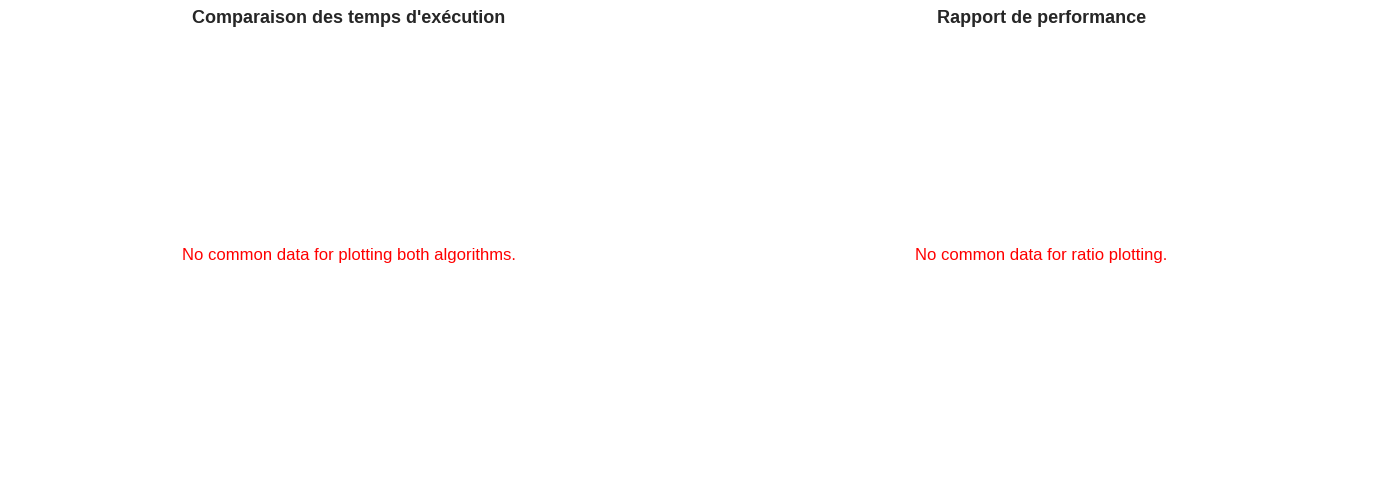


✓ Graphique sauvegardé : benchmark_results.png


In [26]:
def plot_benchmark_results(problem_sizes: List[int], times_gs: List[float], times_csp: List[float]) -> None:
    """
    Trace les graphiques de comparaison des temps d'exécution.

    Args:
        problem_sizes: Tailles de problème testées
        times_gs: Temps Gale-Shapley pour chaque taille
        times_csp: Temps CSP pour chaque taille
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Graphique 1 : Temps d'exécution en échelle linéaire
    ax1 = axes[0]

    # Filter out entries where either GS or CSP failed, and extract data for plotting
    filtered_data_plot1 = []
    for n, tgs, tcsp in zip(problem_sizes, times_gs, times_csp):
        if tgs is not None and tcsp is not None:
            filtered_data_plot1.append((n, tgs * 1000, tcsp * 1000))

    sizes_plot1 = [d[0] for d in filtered_data_plot1]
    gs_times_plot1 = [d[1] for d in filtered_data_plot1]
    csp_times_plot1 = [d[2] for d in filtered_data_plot1]

    if sizes_plot1:
        ax1.plot(sizes_plot1, gs_times_plot1, 'o-', label='Gale-Shapley', linewidth=2, markersize=8, color='#2E86AB')
        ax1.plot(sizes_plot1, csp_times_plot1, 's-', label='CSP (OR-Tools)', linewidth=2, markersize=8, color='#A23B72')
        ax1.set_xlabel('Taille du problème (n)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Temps d\'exécution (ms)', fontsize=12, fontweight='bold')
        ax1.set_title('Comparaison des temps d\'exécution', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, "No common data for plotting both algorithms.", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=12, color='red')
        ax1.set_title('Comparaison des temps d\'exécution', fontsize=13, fontweight='bold')
        ax1.axis('off') # Hide axes if no data

    # Graphique 2 : Ratio CSP/Gale-Shapley
    ax2 = axes[1]
    ratios_plot2 = []
    sizes_plot2 = []
    for n, tgs, tcsp in zip(problem_sizes, times_gs, times_csp):
        if tgs is not None and tcsp is not None and tgs > 0:
            ratios_plot2.append(tcsp / tgs)
            sizes_plot2.append(n)

    if ratios_plot2:
        colors = ['#F18F01' if r > 1 else '#06A77D' for r in ratios_plot2]
        ax2.bar(range(len(ratios_plot2)), ratios_plot2, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax2.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Parité (ratio=1)')
        ax2.set_xticks(range(len(sizes_plot2)))
        ax2.set_xticklabels(sizes_plot2)
        ax2.set_xlabel('Taille du problème (n)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Ratio (CSP / Gale-Shapley)', fontsize=12, fontweight='bold')
        ax2.set_title('Rapport de performance', fontsize=13, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3, axis='y')
    else:
        ax2.text(0.5, 0.5, "No common data for ratio plotting.", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=12, color='red')
        ax2.set_title('Rapport de performance', fontsize=13, fontweight='bold')
        ax2.axis('off') # Hide axes if no data

    plt.tight_layout()
    plt.savefig('benchmark_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✓ Graphique sauvegardé : benchmark_results.png")


# Tracer les résultats
plot_benchmark_results(problem_sizes, times_gs, times_csp)

## Bonus : Visualisation Bipartite (pour petit n)


VISUALISATION BIPARTITE

1. Matching Gale-Shapley (n=5):


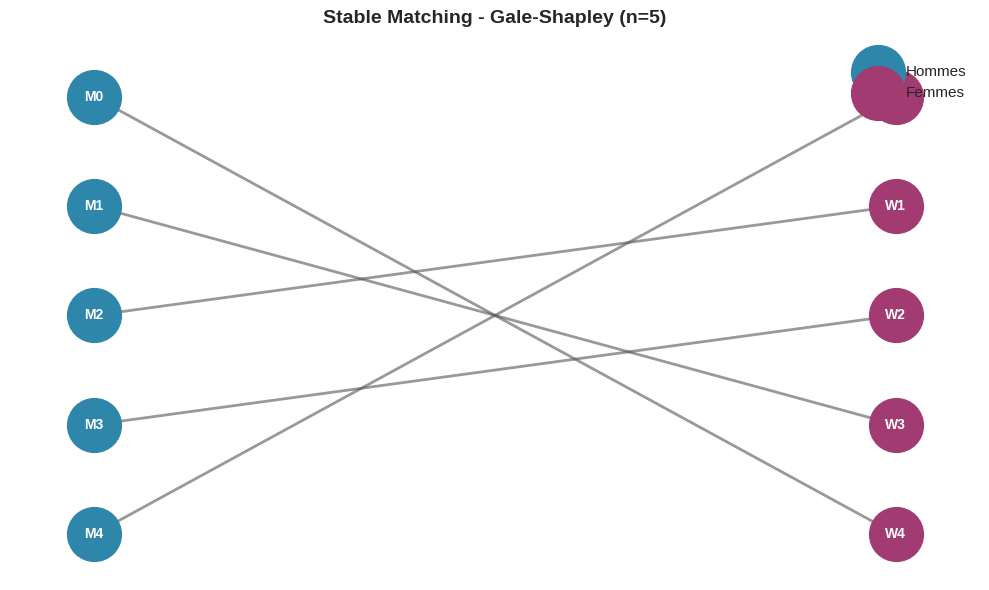

Validation : ✓ STABLE

2. Matching CSP (n=5):
CSP matching non disponible


In [27]:
def visualize_bipartite_matching(matching: Dict[int, int], title: str = "Stable Matching",
                                  men_prefs: np.ndarray = None, women_prefs: np.ndarray = None) -> None:
    """
    Visualise le matching stable sous forme de graphe bipartite.

    Args:
        matching: Dictionnaire {homme: femme}
        title: Titre du graphique
        men_prefs: Matrice de préférences des hommes (optionnel, pour validation)
        women_prefs: Matrice de préférences des femmes (optionnel, pour validation)
    """
    n = len(matching)

    if n > 10:
        print(f"⚠ Visualisation conseillée seulement pour n <= 10 (n={n} risque d'être trop dense)")
        return

    # Créer le graphe bipartite
    G = nx.Graph()

    # Ajouter les nœuds
    men_nodes = [f"M{i}" for i in range(n)]
    women_nodes = [f"W{j}" for j in range(n)]
    G.add_nodes_from(men_nodes, bipartite=0)
    G.add_nodes_from(women_nodes, bipartite=1)

    # Ajouter les arêtes (matching)
    for m, w in matching.items():
        G.add_edge(f"M{m}", f"W{w}")

    # Layout bipartite
    pos = {}
    for i, m in enumerate(men_nodes):
        pos[m] = (0, -i)
    for j, w in enumerate(women_nodes):
        pos[w] = (2, -j)

    # Dessiner
    fig, ax = plt.subplots(figsize=(10, 6))

    # Nœuds hommes (bleu)
    nx.draw_networkx_nodes(G, pos, nodelist=men_nodes, node_color='#2E86AB',
                           node_size=1500, label='Hommes', ax=ax)
    # Nœuds femmes (rose)
    nx.draw_networkx_nodes(G, pos, nodelist=women_nodes, node_color='#A23B72',
                           node_size=1500, label='Femmes', ax=ax)

    # Arêtes
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='#555555', ax=ax)

    # Étiquettes
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='white', ax=ax)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='upper right')
    ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Validation optionnelle
    if men_prefs is not None and women_prefs is not None:
        is_stab, blocking_pairs = is_stable(matching, men_prefs, women_prefs)
        stability_text = "✓ STABLE" if is_stab else f"✗ INSTABLE ({len(blocking_pairs)} paires bloquantes)"
        print(f"Validation : {stability_text}")


# Visualiser les petits exemples
print(f"\n{'='*60}")
print("VISUALISATION BIPARTITE")
print(f"{'='*60}")

# Gale-Shapley
print("\n1. Matching Gale-Shapley (n=5):")
visualize_bipartite_matching(matching_gs, "Stable Matching - Gale-Shapley (n=5)",
                            men_prefs_test, women_prefs_test)

# CSP (si disponible)
try:
    print("\n2. Matching CSP (n=5):")
    visualize_bipartite_matching(matching_csp, "Stable Matching - CSP/OR-Tools (n=5)",
                                men_prefs_test, women_prefs_test)
except:
    print("CSP matching non disponible")

## Résumé et Conclusions

### Points clés de l'implémentation

1. **Gale-Shapley** :
   - Algorithme glouton O(n²)
   - Guaranteed stable matching
   - Déterministe et simple à implémenter

2. **CSP avec OR-Tools** :
   - Modélisation exacte des contraintes
   - Variables : `wife_of[m]` et `husband_of[w]`
   - Contraintes : AllDifferent pour bijection + stabilité
   - Complexité variable (potentiellement exponentielle)

3. **Observations**:
   - Gale-Shapley généralement plus rapide pour n jusqu'à ~100
   - CSP peut devenir prohibitif pour n > 200 selon la qualité du solveur
   - Les deux approches trouvent toujours une solution stable

### Travaux futurs
- Tester avec n=500, 1000
- Optimiser la modélisation CSP (réduire nombre de contraintes)
- Comparer avec d'autres solveurs (PyCSP, MiniZinc)